# Test and Visualize Results

In [1]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader, get_input_data_1D
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Utility funtions

In [2]:
def get_config(json_config_path):
    with open(json_config_path, 'r') as fp:
        best_config = json.load(fp)
    # best_config['dir'] = "./logs/experiments_2D/"
    return best_config


In [3]:
def load_model(params):
    print(f'Loading {params["model_name"]} model...')
    model = Base(input_size=params['input_size'], 
                hidden_size = params["hidden_size"],
                num_layers = params["num_layers"],
                output_size=1 if params['data_dim'] == 1 else 3,
                model = params['model_name']
                )

    # last_checkpoint = 'model_191_0.00757762653609881.pth'
    # last_checkpoint = 'model_132_0.05770279822441248.pth' # lstm ln
    # last_checkpoint = "model_191_917.6316366195679.pth"
    # last_checkpoint = params['dir']

    # print(f'Loading model: {last_checkpoint} from {params["dir"]}...')
    if os.path.isdir(params['dir']):
        chkpoints_list = [i for i in os.listdir(params['dir']) if i.startswith("checkpoint")]
        last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]
        chkpoint_state_dict, optim = torch.load(os.path.join(params['dir'], last_checkpoint, 'checkpoint'))

    else:
        chkpoint_state_dict = torch.load(os.path.join(params['dir']))
    model.load_state_dict(chkpoint_state_dict)
    return model

In [4]:
def test_accuracy(net, test_loader, device="cpu"):
    
    net.to(device)
    net.eval()
    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    loss = 0
    # total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / len(test_loader), np.concatenate(np.array(test_pred), axis=0)


In [5]:
def get_loss(pred, labels, metric = "mae"):
    if metric == "mae":
        criterion = nn.L1Loss()
    elif metric == "mse":
        criterion = nn.MSELoss()
    return criterion(torch.tensor(pred).clone().detach() , torch.tensor(labels)).item()


In [6]:
def get_all_mae(pred, labels, metric):
    all_losses = []
    for i in range(pred.shape[1]): # output size 
        all_losses.append(get_loss(pred[:, i], labels[:, i], metric=metric))
    return all_losses, get_loss(pred[:, 0], labels[:, 0]) # return mse for x, y, theta and total mse


In [7]:
def show_trajectory(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    plt.figure(figsize=(20, 10))
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])    

        # plot x and y on two axis
        # plt.subplot(2, 1, 1)
        plt.plot(nn_preds[:lim, 0], nn_preds[:lim, 1], label='NN pred')
        plt.plot(gt[:lim, 0], gt[:lim, 1], label='GT')
        plt.plot(kalman_pred[:lim, 0], kalman_pred[:lim, 1], label='Kalman pred')
        plt.plot(ekf_pred[:lim, 0], ekf_pred[:lim, 1], label='EKF pred')
        plt.plot(ukf_pred[:lim, 0], ukf_pred[:lim, 1], label='UKF pred')

        plt.legend(['NN pred', 'GT', 'Kalman pred', 'EKF pred', 'UKF pred'])
    

        # # plt.subplot(3, 1, 1)
        # plt.plot(nn_preds[:lim, 0], label='X pred')
        # plt.plot(gt[:lim, 0], label='X true')
        # plt.plot(kalman_pred[:lim, 0], label='X kalman')
        # plt.plot(ekf_pred[:lim, 0], label='X EKF')
        # plt.plot(ukf_pred[:lim, 0], label='X UKF')
        # plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        # # plt.subplot(3, 1, 2)
        # plt.plot(nn_preds[:lim, 1], label='Y pred')
        # plt.plot(gt[:lim, 1], label='Y true')
        # plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        # plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        # plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        # plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        # plt.subplot(3, 1, 3)
        # plt.plot(nn_preds[:lim, 2], label='Theta pred')
        # plt.plot(gt[:lim, 2], label='Theta true')
        # plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        # plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        # plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        # plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        # if save_plots:
        #     plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [8]:
def show_plots(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        plt.figure(figsize=(20, 10))
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])
        # ekf_pred = np.array(dataset[3])
        # ukf_pred = np.array(dataset[4])    

        plt.subplot(3, 1, 1)
        plt.plot(nn_preds[:lim, 0], label='X pred')
        plt.plot(gt[:lim, 0], label='X true')
        plt.plot(kalman_pred[:lim, 0], label='X kalman')
        plt.plot(ekf_pred[:lim, 0], label='X EKF')
        plt.plot(ukf_pred[:lim, 0], label='X UKF')
        plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        plt.subplot(3, 1, 2)
        plt.plot(nn_preds[:lim, 1], label='Y pred')
        plt.plot(gt[:lim, 1], label='Y true')
        plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        plt.subplot(3, 1, 3)
        plt.plot(nn_preds[:lim, 2], label='Theta pred')
        plt.plot(gt[:lim, 2], label='Theta true')
        plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.figure(figsize=(15, 8))
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        # plt.plot(ekf_pred[:lim], label='EKF pred')
        # plt.plot(ukf_pred[:lim], label='UKF pred')
        # plt.legend(['NN pred', 'GT', 'Kalman Pred', 'EKF pred', 'UKF pred'])
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [9]:
def get_csv_results(eval_csv_dir, params):
    config = get_config(params["json_config_path"])
    config.update(params)
    print(f"config: {config}")

    model = load_model(config)

    # test_df = pd.read_csv(EVAL_DATA_DIR)
    if params["data_dim"] == 2:
        test_dataset = get_input_data(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)

        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        ekf_pred = np.array(test_dataset[3])
        ukf_pred = np.array(test_dataset[4])
        
        nn_loss_dims, nn_loss = get_all_mae(nn_preds, test_dataset[1], metric=params['loss'])
        # print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mae(kalman_pred, test_dataset[1], metric=params['loss'])
        # print(f"KF MSE: {kf_loss_dims}, {kf_loss}")
        ekf_loss_dims, ekf_loss = get_all_mae(ekf_pred, test_dataset[1], metric=params['loss'])
        # print(f"EKF MSE: {ekf_loss_dims}, {ekf_loss}")
        ukf_loss_dims, ukf_loss = get_all_mae(ukf_pred, test_dataset[1], metric=params['loss'])
        # print(f"UKF MSE: {ukf_loss_dims}, {ukf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss

    else:
        test_dataset = get_input_data_1D(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
        
        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        print(f'len test loader: {len(test_loader)}')
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")
        print(f"Test dataset shape: {len(test_dataset)} and  {test_dataset[0].shape}")

        kalman_pred = np.array(test_dataset[2])
        # ekf_pred = np.array(test_dataset[3])
        # ukf_pred = np.array(test_dataset[4])

        nn_loss = get_loss(nn_preds, test_dataset[1])
        print(f"NN MSE: {nn_loss}")
        kf_loss = get_loss(kalman_pred, test_dataset[1])
        print(f"KF MSE: {kf_loss}")
        # ekf_loss = get_loss(ekf_pred, test_dataset[1])
        # print(f"EKF MSE: {ekf_loss}")
        # ukf_loss = get_loss(ukf_pred, test_dataset[1])
        # print(f"UKF MSE: {ukf_loss}")


        # nn_loss_dims, nn_loss = (nn_preds, test_dataset[1])
        # print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        # kf_loss_dims, kf_loss = get_all_mae(kalman_pred, test_dataset[1])
        # print(f"KF MSE: {kf_loss_dims}, {kf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        # return nn_loss, kf_loss, ekf_loss, ukf_loss
        return nn_loss, kf_loss




In [10]:
def get_results(params, test_set_name, data_dim=2, model_name="LSTM_ln"):
    if data_dim == 2:
        kalman_mse_x = []
        kalman_mse_y = []
        kalman_mse_theta = []

        nn_mse_x = []
        nn_mse_y = []
        nn_mse_theta = []

        ekf_mse_x = []
        ekf_mse_y = []
        ekf_mse_theta = []

        ukf_mse_x = []
        ukf_mse_y = []
        ukf_mse_theta = []

        kalman_mse_total = []
        nn_mse_total = []
        ekf_mse_total = []
        ukf_mse_total = []

        test_set = []
        test_model = []

        for csv_name in os.listdir(params['eval_dir_path']):
            csv_dir = os.path.join(params['eval_dir_path'], csv_name)
            params['save_name'] = csv_name.split(".")[0] # for saving plots
            mse_array = get_csv_results(csv_dir, params)

            kf_loss_dims = mse_array[0]
            kf_loss = mse_array[1]
            nn_loss_dims = mse_array[2]
            nn_loss = mse_array[3]
            ekf_loss_dims = mse_array[4]
            ekf_loss = mse_array[5]
            ukf_loss_dims = mse_array[6]
            ukf_loss = mse_array[7]

            kalman_mse_total.append(kf_loss)
            nn_mse_total.append(nn_loss)
            ekf_mse_total.append(ekf_loss)
            ukf_mse_total.append(ukf_loss)

            kalman_mse_x.append(kf_loss_dims[0])
            kalman_mse_y.append(kf_loss_dims[1])
            kalman_mse_theta.append(kf_loss_dims[2])

            ekf_mse_x.append(ekf_loss_dims[0])
            ekf_mse_y.append(ekf_loss_dims[1])
            ekf_mse_theta.append(ekf_loss_dims[2])

            ukf_mse_x.append(ukf_loss_dims[0])
            ukf_mse_y.append(ukf_loss_dims[1])
            ukf_mse_theta.append(ukf_loss_dims[2])

            nn_mse_x.append(nn_loss_dims[0])
            nn_mse_y.append(nn_loss_dims[1])
            nn_mse_theta.append(nn_loss_dims[2])

            test_set.append(csv_dir)
            test_model.append(model_name)


            print("====================================")
            print("====================================")
            print("====================================")

        results_dict = {
            "Test set": [test_set_name[i] for i in test_set],
            "Test model": test_model,

            "Total Kalman MSe": kalman_mse_total,
            "Total NN MSE": nn_mse_total,
            "Total EKF MSE": ekf_mse_total,
            "Total UKF MSE": ukf_mse_total,

            "Kalman MSE X": kalman_mse_x,
            "NN MSE X": nn_mse_x,
            "EKF MSE X": ekf_mse_x,
            "UKF MSE X": ukf_mse_x,

            "Kalman MSE Y": kalman_mse_y,
            "NN MSE Y": nn_mse_y,
            "EKF MSE Y": ekf_mse_y,
            "UKF MSE Y": ukf_mse_y,

            "Kalman MSE Theta": kalman_mse_theta,
            "NN MSE Theta": nn_mse_theta,
            "EKF MSE Theta": ekf_mse_theta,
            "UKF MSE Theta": ukf_mse_theta,
        }

        lstm_2d_results_df = pd.DataFrame.from_dict(results_dict)
        
        return lstm_2d_results_df

    if data_dim == 1:
            kalman_mse_x = []
            nn_mse_x = []
            ekf_mse_x = []
            ukf_mse_x = []

            kalman_mse_total = []
            nn_mse_total = []
            ekf_mse_total = []
            ukf_mse_total = []

            test_set = []
            test_model = []

            for csv_name in os.listdir(params['eval_dir_path']):
                csv_dir = os.path.join(params['eval_dir_path'], csv_name)

                params['save_name'] = csv_name.split(".")[0] # for saving plots
                mse_array = get_csv_results(csv_dir, params)

                nn_loss = mse_array[0]
                kf_loss = mse_array[1]

                kalman_mse_total.append(kf_loss)
                nn_mse_total.append(nn_loss)

                test_set.append(csv_dir)
                test_model.append(model_name)


                print("====================================")
                print("====================================")
                print("====================================")

            results_dict = {
                "Test set": [test_set_name[i] for i in test_set],
                "Test model": test_model,

                "Total Kalman MSe": kalman_mse_total,
                "Total NN MSE": nn_mse_total,
            }

            total_results_1d = pd.DataFrame.from_dict(results_dict)
            
            return total_results_1d

In [11]:
def test_setup(data_dim, model_name="LSTM_ln", save_plots=True, loss_metric = 'mae', plot_lim = -1, dataset = None):
    if dataset != None:     
        json_config_path = f'./logs/separate_mae/experiments_{data_dim}D/{dataset}/best_config_{model_name}.json'
    else:
        json_config_path = f'./logs/appended_mae/experiments_{data_dim}D/best_config_{model_name}.json'
         
         
    eval_dir_path = f"data/{data_dim}D/evaluation_data"

    params = {
        "batch_size": 100,
        "model_name": model_name,
        "input_size": 19 if data_dim == 2 else 9,
        "output_size": 3 if data_dim == 2 else 1,
        'model_name': model_name,
        'data_dim': data_dim,
        "json_config_path": json_config_path,
        "data_dim": data_dim,
        "plot_limit": plot_lim, # -1 for all
        "save_plots": save_plots,
        "save_dir": f"./results/{data_dim}D/{model_name}/plots",
        'eval_dir_path': eval_dir_path,
        'loss': loss_metric,
    }

    if data_dim == 2:
            test_set_name = {
                            'data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv': 'Intel 1',
                            'data/2D/evaluation_data/fbcampus_alpha_4_run_2_merged.csv': 'FB Campus 1',
                            'data/2D/evaluation_data/fbcampus_alpha_8_run_2_merged.csv': 'FB Campus 2',
                            'data/2D/evaluation_data/intel_alpha_4_run_2_merged.csv': 'Intel 2'
                }
    else:
        test_set_name = {
                        'data/1D/evaluation_data/mnst_2_lnstd_10.csv': 'MNST 0',
                        'data/1D/evaluation_data/mnst_2_lnstd_0.01.csv': 'MNST 1',
                        'data/1D/evaluation_data/mnst_4_lnstd_0.01.csv': 'MNST 2',
                        'data/1D/evaluation_data/mnst_2_lnstd_1.csv': 'MNST 3',
                        'data/1D/evaluation_data/mnst_2_lnstd_0.1.csv': 'MNST 4',
                        'data/1D/evaluation_data/mnst_8_lnstd_0.01.csv': 'MNST 5'
                        }

    os.makedirs(params["save_dir"], exist_ok=True)

    return params, test_set_name

In [12]:
def save_results(all_resutls_df, model_name="LSTM_ln", data_dim=2):
    os.makedirs(f'./results/{data_dim}D/{model_name}/', exist_ok=True)
    if data_dim == 2:
        lstm_ln_2d_results_all = all_resutls_df[['Test set', 'Test model', 'Total Kalman MSe', 'Total NN MSE', 'Total EKF MSE', 'Total UKF MSE']]
        lstm_ln_2d_results_x = all_resutls_df[['Test set', 'Test model', 'Kalman MSE X', 'NN MSE X', 'EKF MSE X', 'UKF MSE X']]
        lstm_ln_2d_results_y = all_resutls_df[['Test set', 'Test model', 'Kalman MSE Y', 'NN MSE Y', 'EKF MSE Y', 'UKF MSE Y']]
        lstm_ln_2d_results_theta = all_resutls_df[['Test set', 'Test model', 'Kalman MSE Theta', 'NN MSE Theta', 'EKF MSE Theta', 'UKF MSE Theta']]
        # lstm_ln_2d_results_all

        lstm_ln_2d_results_all.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_overall.csv")
        lstm_ln_2d_results_x.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_x.csv")
        lstm_ln_2d_results_y.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_y.csv")
        lstm_ln_2d_results_theta.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_theta.csv")

    elif data_dim == 1:
        over_all_df = all_resutls_df[['Test set','Test model', 'Total Kalman MSe', 'Total NN MSE']]
        over_all_df.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results_overall.csv")


# 2D Results

## LSTM_LN

In [13]:
data_dim = 2
model_name = 'LSTM_ln'
params, test_set_name = test_setup(data_dim=2, model_name=model_name)

all_resutls_df = get_results(params, test_set_name, model_name=model_name)

# save_results(all_resutls_df, model_name=model_name, data_dim=data_dim)

FileNotFoundError: [Errno 2] No such file or directory: './logs/appended_mae/experiments_2D/best_config_LSTM_ln.json'

In [25]:
get_config(params["json_config_path"])


{'dir': '/home/rufael.marew/ray_results/train_ray_2023-05-07_19-59-20/train_ray_22a6a_00010_10_hidden_size=16,lr=0.0003,num_layers=12,sequence_length=14_2023-05-07_20-11-43',
 'hidden_size': 16,
 'lr': 0.00030107987499436694,
 'metric': 0.13527004569768905,
 'num_layers': 12,
 'sequence_length': 14}

In [20]:
params

{'batch_size': 100,
 'model_name': 'LSTM_ln',
 'input_size': 19,
 'output_size': 3,
 'data_dim': 2,
 'json_config_path': './logs/appended_mae/experiments_2D/best_config_LSTM_ln.json',
 'plot_limit': -1,
 'save_plots': True,
 'save_dir': './results/2D/LSTM_ln/plots',
 'eval_dir_path': 'data/2D/evaluation_data',
 'loss': 'mae'}

## LSTM 

In [37]:
all_resutls_df
# test_set_name



,Test set,Test model,Total Kalman MSe,Total NN MSE,Total EKF MSE,Total UKF MSE,Kalman MSE X,NN MSE X,EKF MSE X,UKF MSE X,Kalman MSE Y,NN MSE Y,EKF MSE Y,UKF MSE Y,Kalman MSE Theta,NN MSE Theta,EKF MSE Theta,UKF MSE Theta
0,FB Campus 2,LSTM,0.078613,0.122657,0.026203,0.260478,0.078613,0.122657,0.026203,0.260478,0.079829,0.205933,0.007583,0.233076,0.166582,0.655056,0.824231,0.188952
1,Intel 1,LSTM,0.044180,0.168005,0.038003,0.019466,0.044180,0.168005,0.038003,0.019466,0.021308,0.091361,0.025946,0.038701,0.342355,0.535246,0.422663,0.423152
2,Intel 2,LSTM,0.032754,0.160518,0.039427,0.029918,0.032754,0.160518,0.039427,0.029918,0.013613,0.090834,0.041805,0.078142,0.183666,0.281827,0.214339,0.209185
3,FB Campus 1,LSTM,0.033728,0.176291,0.020327,0.339105,0.033728,0.176291,0.020327,0.339105,0.064715,0.124412,0.025449,0.357053,0.266904,0.554103,0.050467,0.071311


In [15]:
all_resutls_df

,Test set,Test model,Total Kalman MSe,Total NN MSE,Total EKF MSE,Total UKF MSE,Kalman MSE X,NN MSE X,EKF MSE X,UKF MSE X,Kalman MSE Y,NN MSE Y,EKF MSE Y,UKF MSE Y,Kalman MSE Theta,NN MSE Theta,EKF MSE Theta,UKF MSE Theta
0,FB Campus 2,LSTM,0.078613,0.232812,0.026203,0.260478,0.078613,0.232812,0.026203,0.260478,0.079829,0.201603,0.007583,0.233076,0.166582,0.515821,0.824231,0.188952
1,Intel 1,LSTM,0.044180,0.081515,0.038003,0.019466,0.044180,0.081515,0.038003,0.019466,0.021308,0.068053,0.025946,0.038701,0.342355,0.375983,0.422663,0.423152
2,Intel 2,LSTM,0.032754,0.086087,0.039427,0.029918,0.032754,0.086087,0.039427,0.029918,0.013613,0.093015,0.041805,0.078142,0.183666,0.277921,0.214339,0.209185
3,FB Campus 1,LSTM,0.033728,0.083158,0.020327,0.339105,0.033728,0.083158,0.020327,0.339105,0.064715,0.114808,0.025449,0.357053,0.266904,0.286017,0.050467,0.071311


config: {'dir': 'logs/appended_mae/experiments_2D/model_best_LSTM.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_20-31-33/train_ray_a2b3c_00009_9_hidden_size=8,lr=0.0006,num_layers=12,sequence_length=38_2023-05-07_20-53-03', 'hidden_size': 8, 'lr': 0.0005522389433178991, 'metric': 0.1475361283008869, 'num_layers': 12, 'sequence_length': 38, 'batch_size': 100, 'model_name': 'LSTM', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_LSTM.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/2D/LSTM/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading LSTM model...
Test loss: 0.15155093273834178
config: {'dir': 'logs/appended_mae/experiments_2D/model_best_LSTM.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_20-31-33/train_ray_a2b3c_00009_9_hidden_size=8,lr=0.0006,num_layers=12,sequence_length=38_2023-

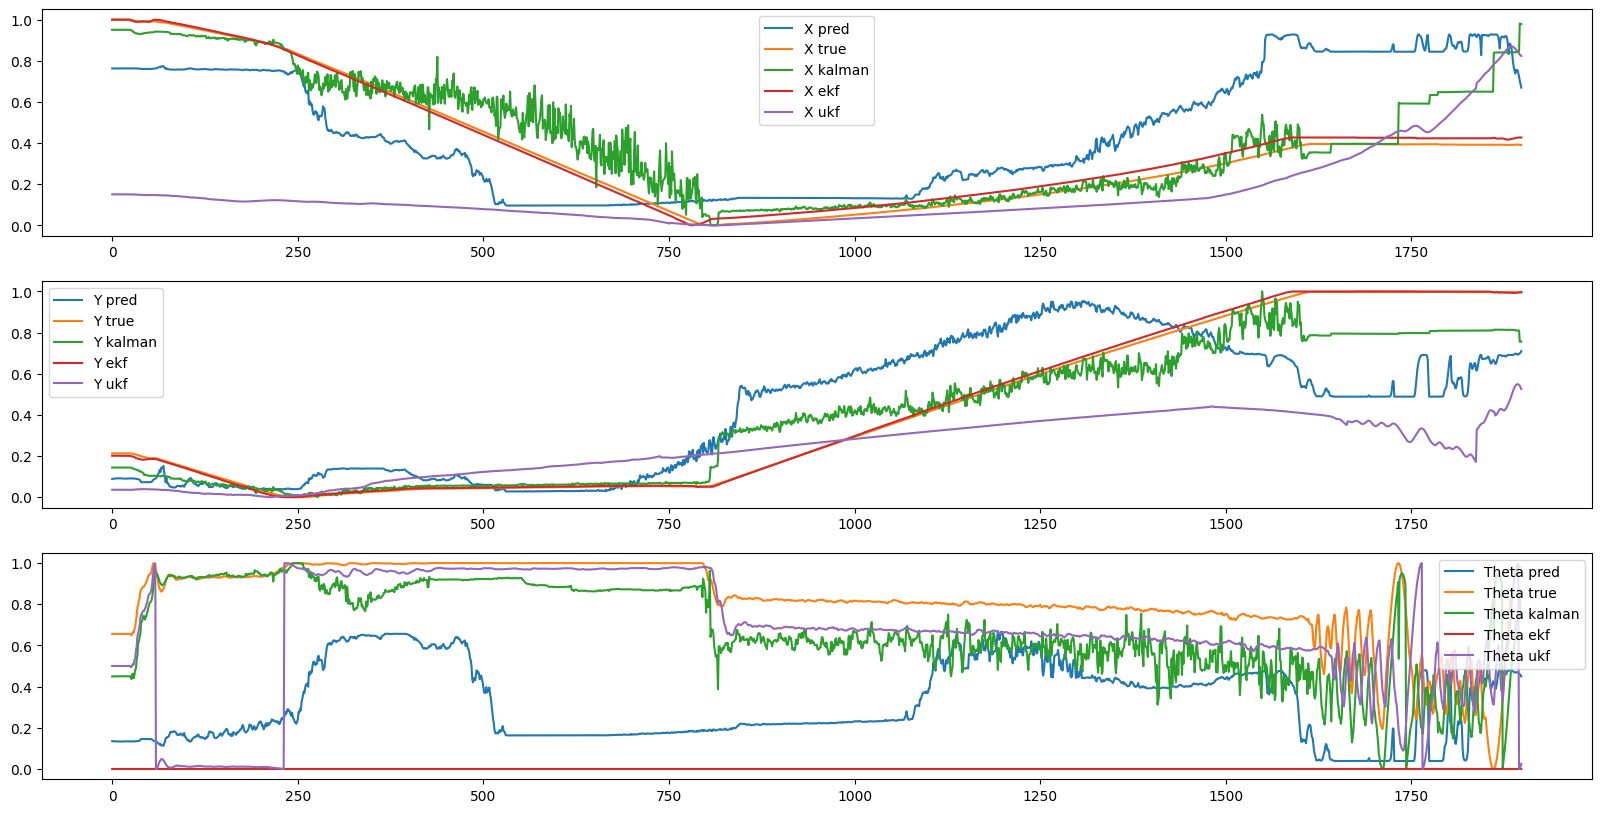

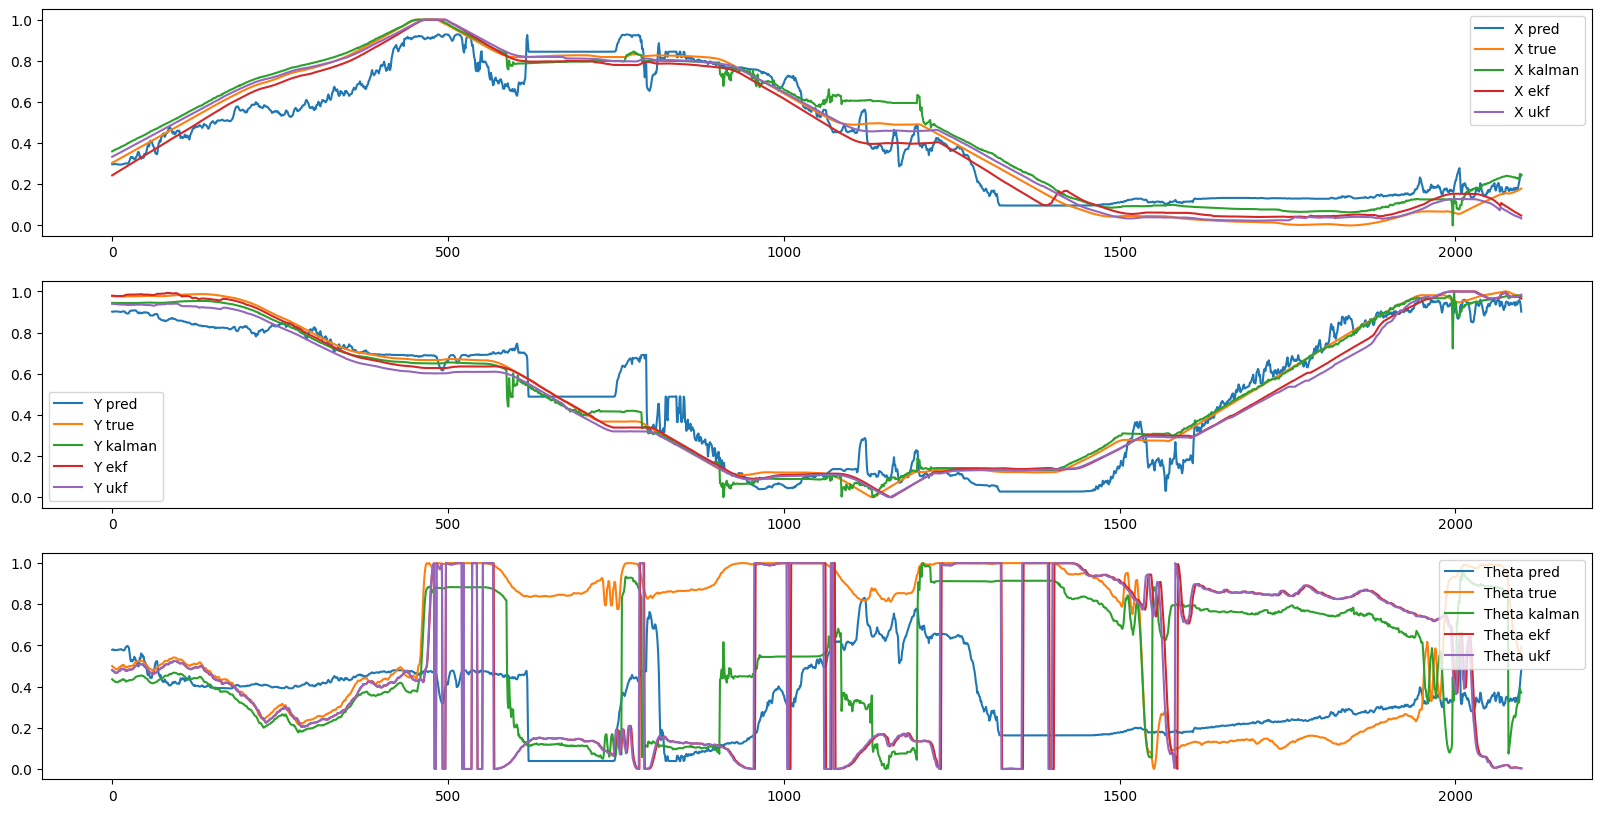

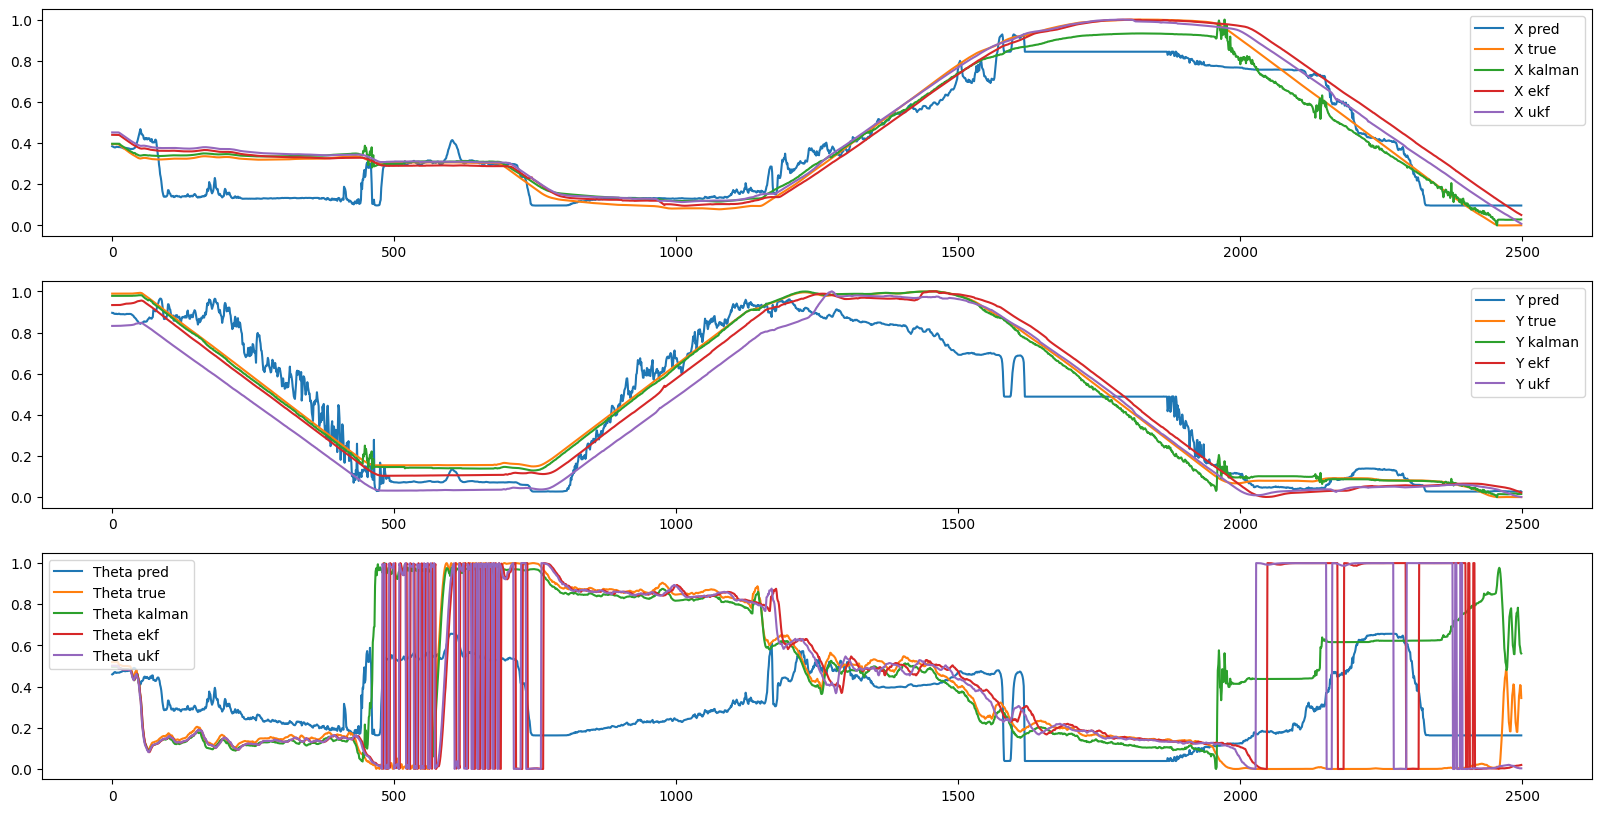

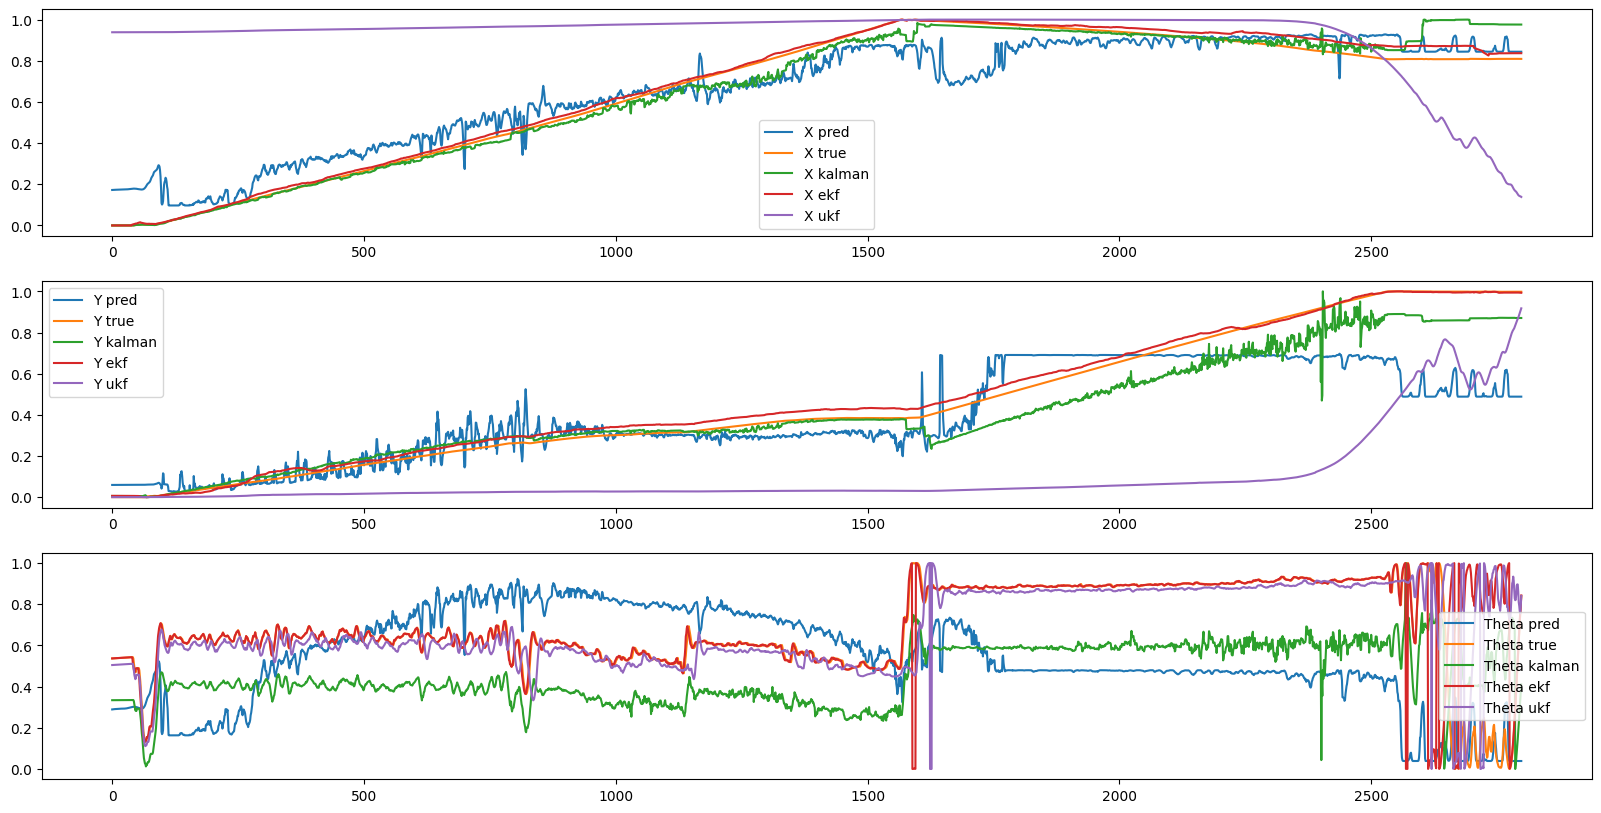

In [14]:
data_dim = 2
model_name = "LSTM"
params, test_set_name = test_setup(data_dim=2, model_name=model_name)
# params, test_set_name = test_setup(data_dim=2, model_name=model_name, dataset='generated_data_fbcampus_alpha_4')


all_resutls_df = get_results(params, test_set_name, model_name=model_name)

# save_results(all_resutls_df, model_name=model_name, data_dim=data_dim)

## RNN

In [19]:
rnn_2d_results_df

,Test set,Test model,Total Kalman MSe,Total NN MSE,Total EKF MSE,Total UKF MSE,Kalman MSE X,NN MSE X,EKF MSE X,UKF MSE X,Kalman MSE Y,NN MSE Y,EKF MSE Y,UKF MSE Y,Kalman MSE Theta,NN MSE Theta,EKF MSE Theta,UKF MSE Theta
0,FB Campus 2,RNN,0.083720,0.276497,0.026513,0.256703,0.083720,0.276497,0.026513,0.256703,0.081445,0.247446,0.007485,0.236466,0.167675,0.586233,0.824036,0.191017
1,Intel 1,RNN,0.044189,0.127217,0.038964,0.020763,0.044189,0.127217,0.038964,0.020763,0.021087,0.134750,0.026125,0.038490,0.344631,0.518094,0.428222,0.428696
2,Intel 2,RNN,0.032945,0.160035,0.039323,0.029513,0.032945,0.160035,0.039323,0.029513,0.013641,0.136850,0.041488,0.077017,0.186673,0.251843,0.216003,0.210921
3,FB Campus 1,RNN,0.034800,0.127757,0.020505,0.337692,0.034800,0.127757,0.020505,0.337692,0.065498,0.096732,0.025454,0.357440,0.268063,0.498081,0.050477,0.071393


In [17]:
rnn_2d_results_df

,Test set,Test model,Total Kalman MSe,Total NN MSE,Total EKF MSE,Total UKF MSE,Kalman MSE X,NN MSE X,EKF MSE X,UKF MSE X,Kalman MSE Y,NN MSE Y,EKF MSE Y,UKF MSE Y,Kalman MSE Theta,NN MSE Theta,EKF MSE Theta,UKF MSE Theta
0,FB Campus 2,RNN,0.098043,0.197057,0.026065,0.276859,0.098043,0.197057,0.026065,0.276859,0.086014,0.158254,0.007464,0.237760,0.172463,0.505699,0.821626,0.194295
1,Intel 1,RNN,0.044538,0.104039,0.041887,0.023587,0.044538,0.104039,0.041887,0.023587,0.021130,0.057552,0.027252,0.040529,0.345772,0.398596,0.424127,0.424438
2,Intel 2,RNN,0.032501,0.135154,0.039212,0.030222,0.032501,0.135154,0.039212,0.030222,0.013566,0.056650,0.042029,0.079582,0.180239,0.294909,0.211851,0.206662
3,FB Campus 1,RNN,0.032300,0.120441,0.020092,0.341631,0.032300,0.120441,0.020092,0.341631,0.063672,0.063606,0.025465,0.355760,0.264503,0.203285,0.050383,0.067660


config: {'dir': 'logs/appended_mae/experiments_2D/model_best_RNN.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_19-59-20/train_ray_22a6a_00010_10_hidden_size=16,lr=0.0003,num_layers=12,sequence_length=14_2023-05-07_20-11-43', 'hidden_size': 16, 'lr': 0.00030107987499436694, 'metric': 0.13527004569768905, 'num_layers': 12, 'sequence_length': 14, 'batch_size': 100, 'model_name': 'RNN', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': './logs/appended_mae/experiments_2D/best_config_RNN.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/2D/RNN/plots', 'eval_dir_path': 'data/2D/evaluation_data', 'loss': 'mae', 'save_name': 'fbcampus_alpha_8_run_2_merged'}
Loading RNN model...
Test loss: 0.14165683072060348
config: {'dir': 'logs/appended_mae/experiments_2D/model_best_RNN.pth', 'dir_2': '/home/rufael.marew/ray_results/train_ray_2023-05-07_19-59-20/train_ray_22a6a_00010_10_hidden_size=16,lr=0.0003,num_layers=12,sequence_length=14_2023

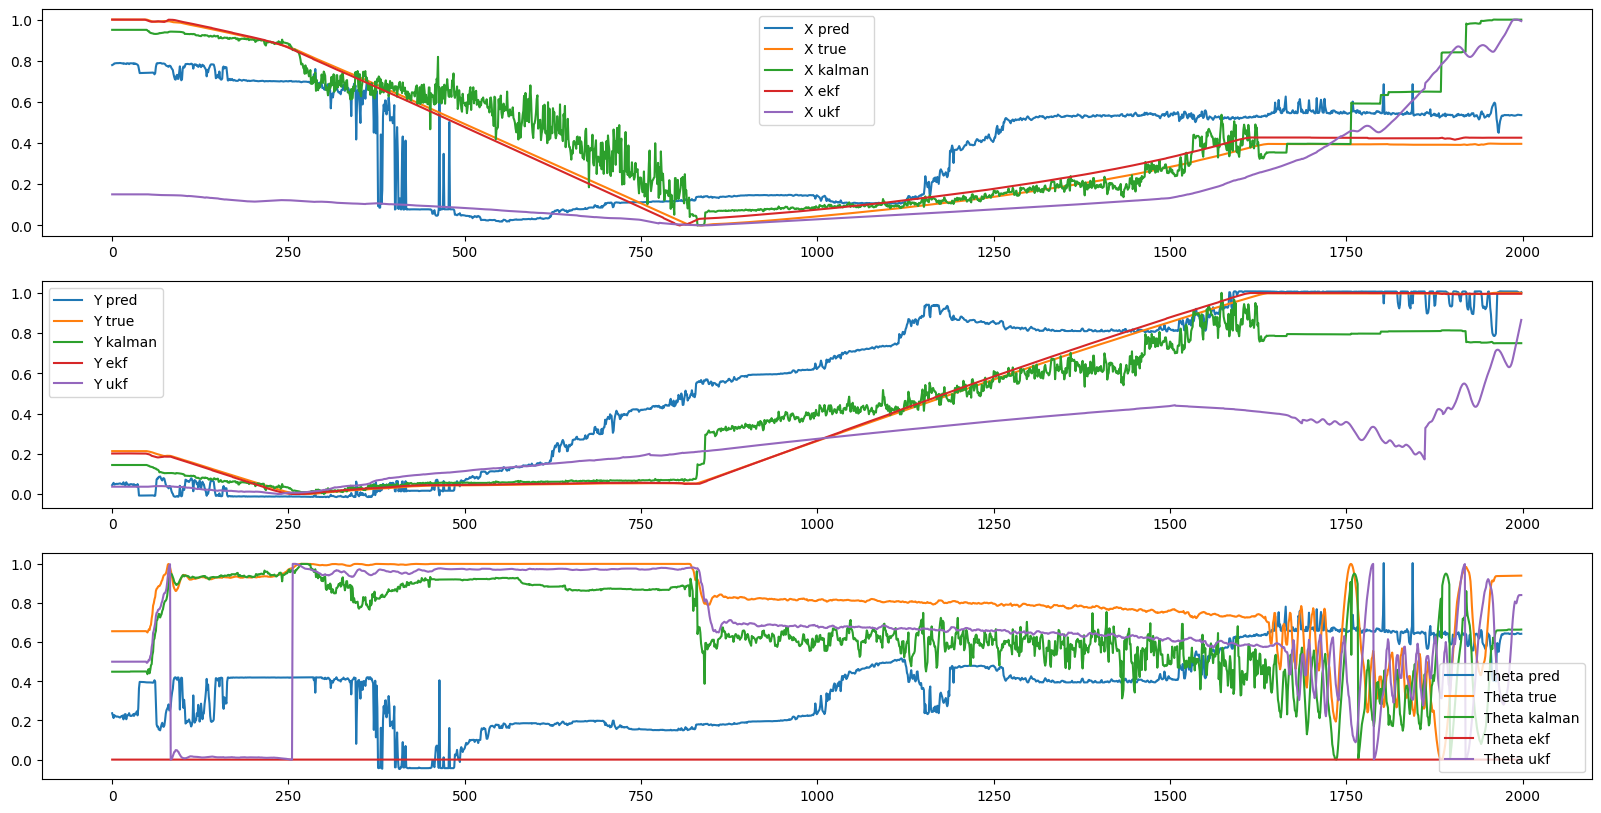

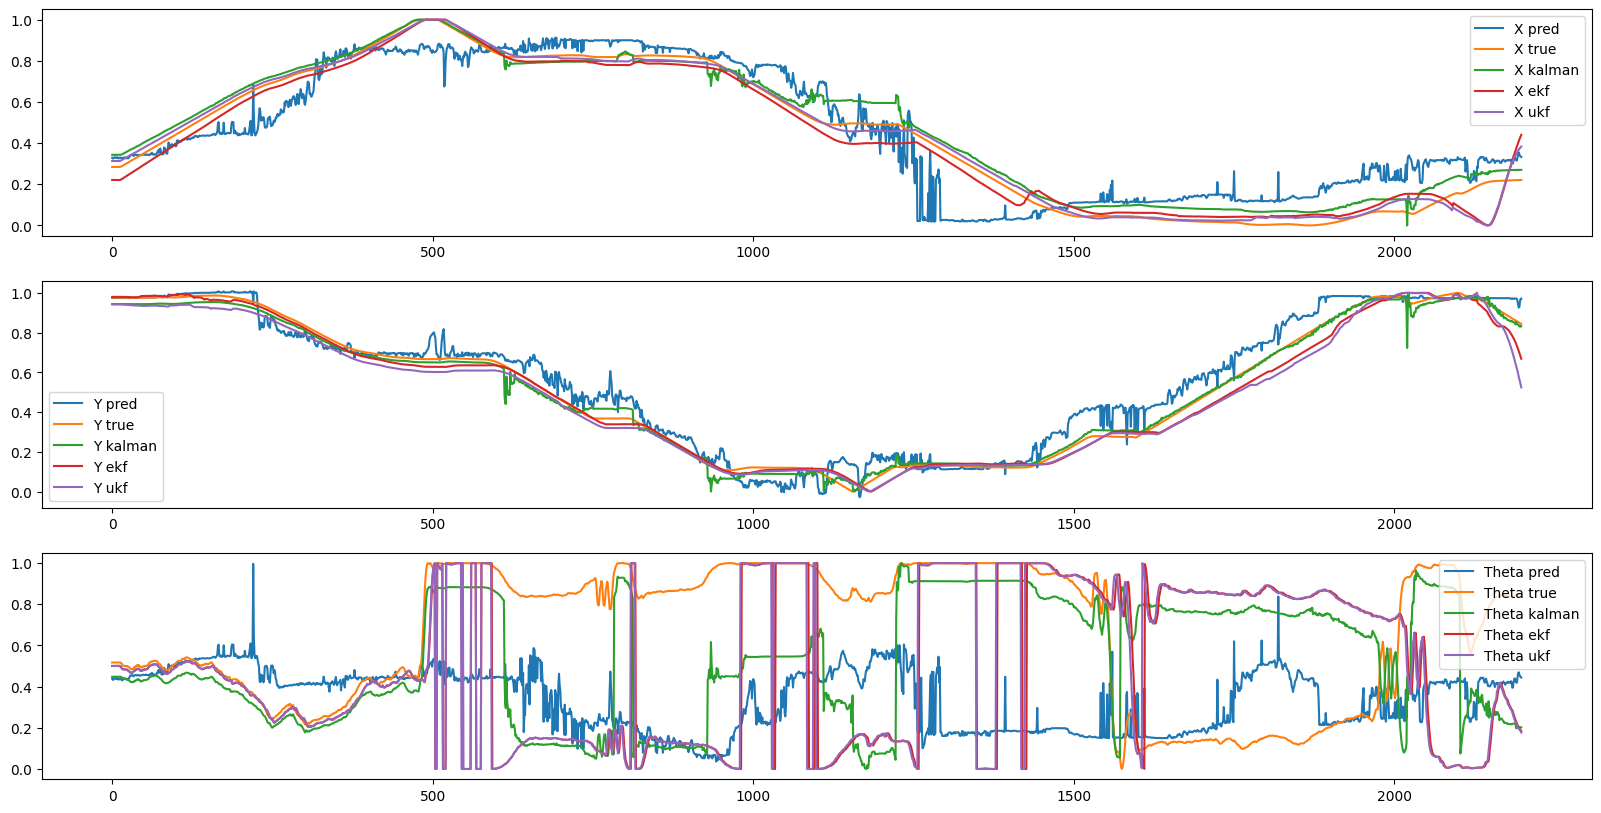

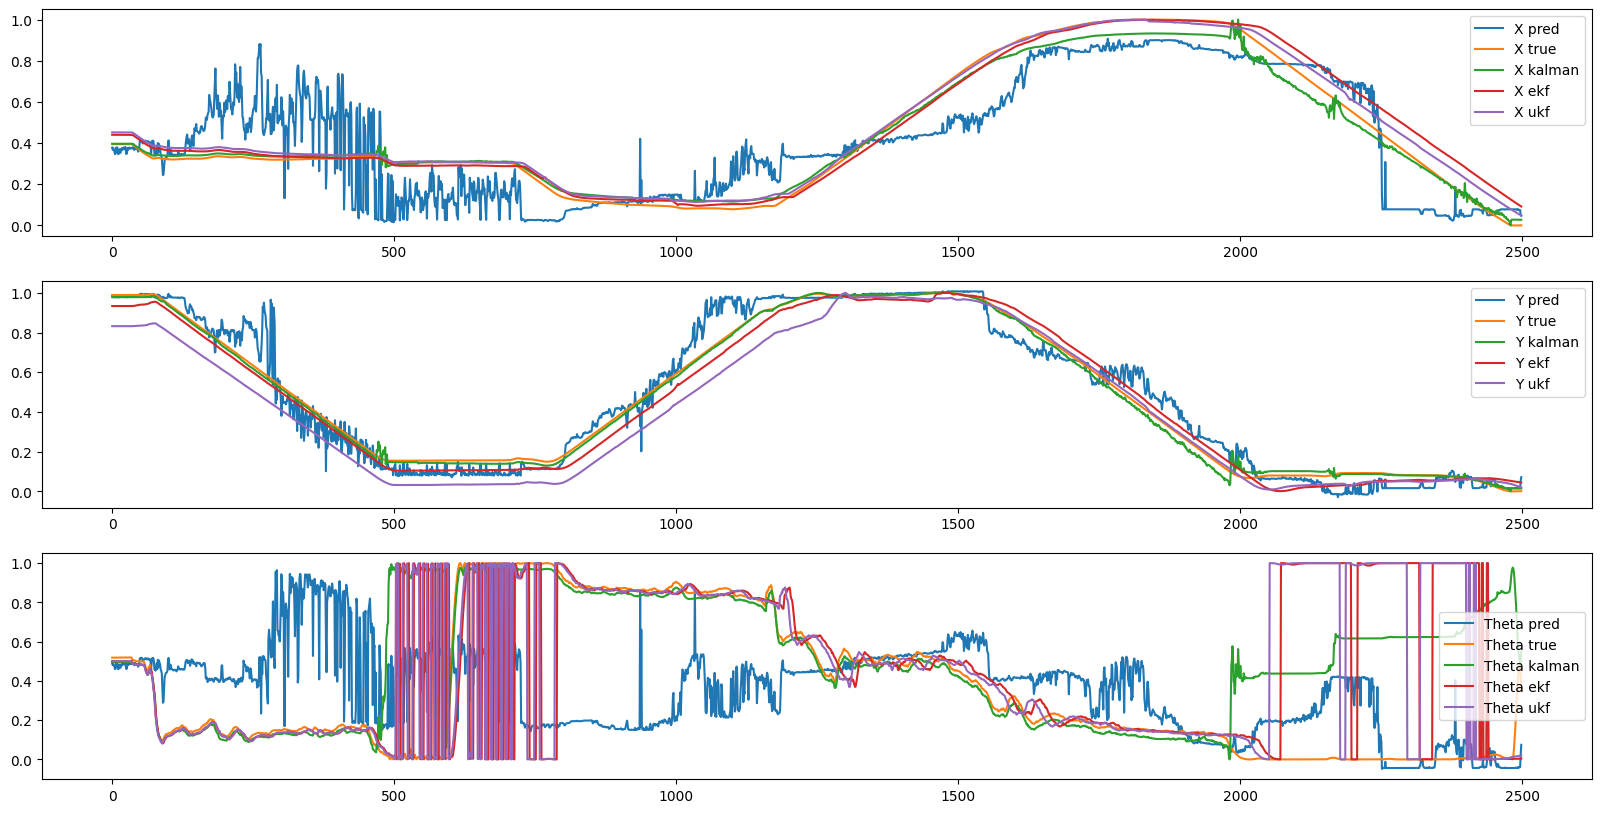

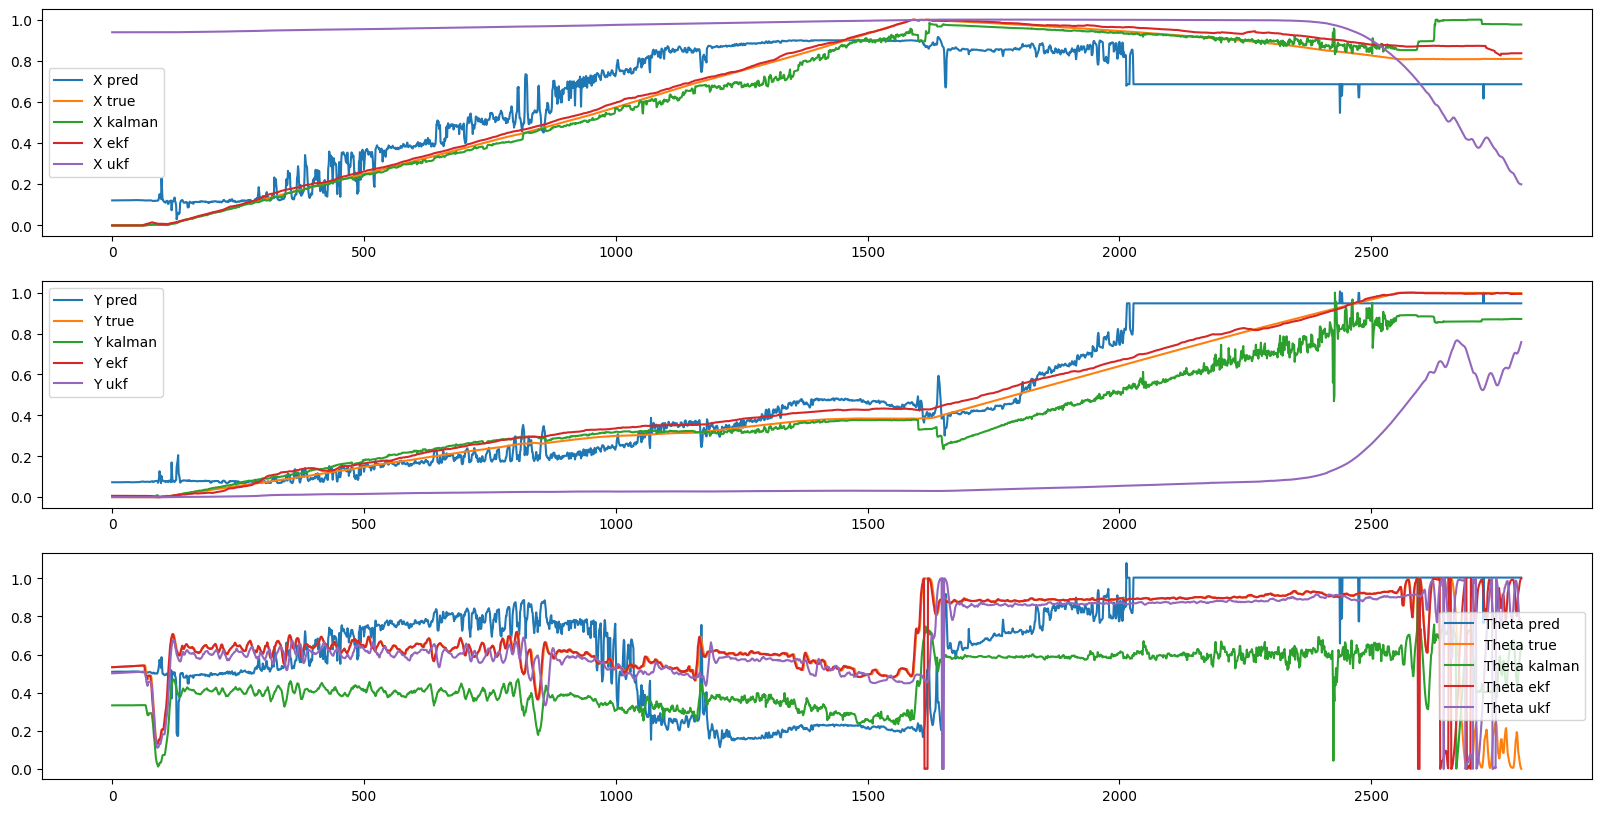

In [16]:
data_dim = 2
model_name = "RNN"
params, test_set_name = test_setup(data_dim=2, model_name=model_name)
# params, test_set_name = test_setup(data_dim=2, model_name=model_name, dataset='generated_data_fbcampus_alpha_4')
rnn_2d_results_df = get_results(params, test_set_name, model_name=model_name)
save_results(rnn_2d_results_df, model_name=model_name, data_dim=data_dim)

# 1D Results

## LSTM

In [19]:
data_dim = 1
model_name = "LSTM"
params, test_set_name = test_setup(data_dim=1, model_name=model_name)
params['batch_size'] = 20
all_resutls_df = get_results(params, test_set_name, model_name=model_name, data_dim=data_dim)
save_results(all_resutls_df, data_dim=1, model_name=model_name)
all_resutls_df


## RNN

config: {'dir': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/RNN/models/model_188_1002.3156089782715.pth', 'hidden_size': 32, 'lr': 0.0017556246933097342, 'metric': 1.5923599917441607, 'num_layers': 2, 'sequence_length': 56, 'batch_size': 20, 'model_name': 'RNN', 'input_size': 9, 'output_size': 1, 'data_dim': 1, 'json_config_path': './logs/experiments_1D/best_config_RNN.json', 'plot_limit': -1, 'save_plots': True, 'save_dir': './results/1D/RNN/plots', 'eval_dir_path': 'data/1D/evaluation_data', 'loss': 'mae', 'save_name': 'mnst_2_lnstd_10'}
Loading RNN model...
len test loader: 8
Test loss: 3.481118857860565
Test dataset shape: 3 and  (160, 56, 9)
NN MSE: 1.1716834731530743
KF MSE: 6.678725155831527
config: {'dir': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/RNN/models/model_188_1002.3156089782715.pth', 'hidden_size': 32, 'lr': 0.0017556246933097342, 'metric': 1.5923599917441607, 'num_layers': 2, 'sequence_length': 56, 'batch_size': 20, 'model_n

,Test set,Test model,Total Kalman MSe,Total NN MSE
0,MNST 0,RNN,6.678725,1.171683
1,MNST 1,RNN,0.777548,1.045934
2,MNST 2,RNN,0.769939,0.391995
3,MNST 3,RNN,1.619172,0.343402
4,MNST 4,RNN,0.778207,0.311721
5,MNST 5,RNN,0.742409,0.738226


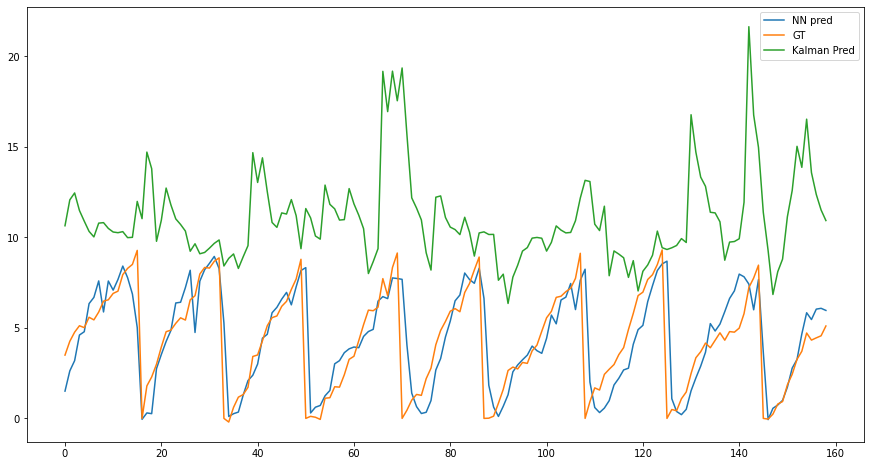

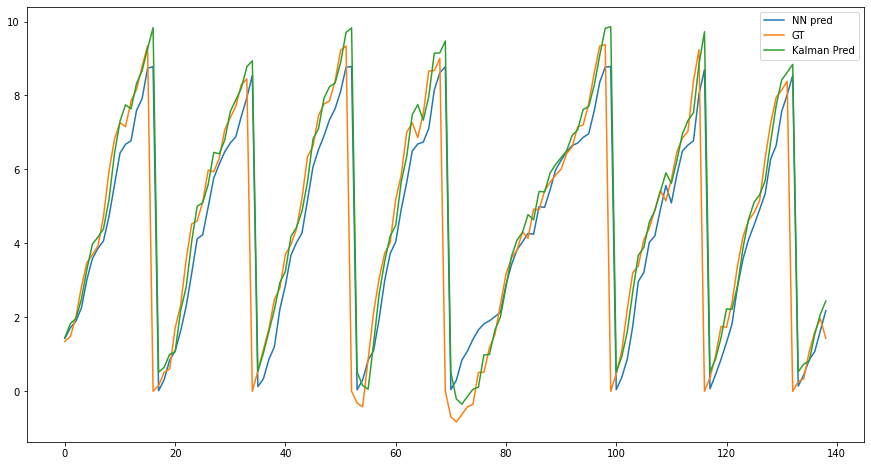

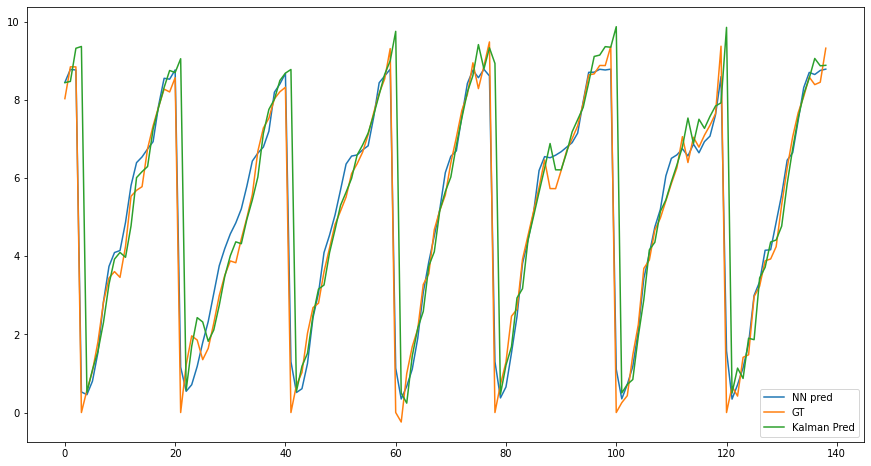

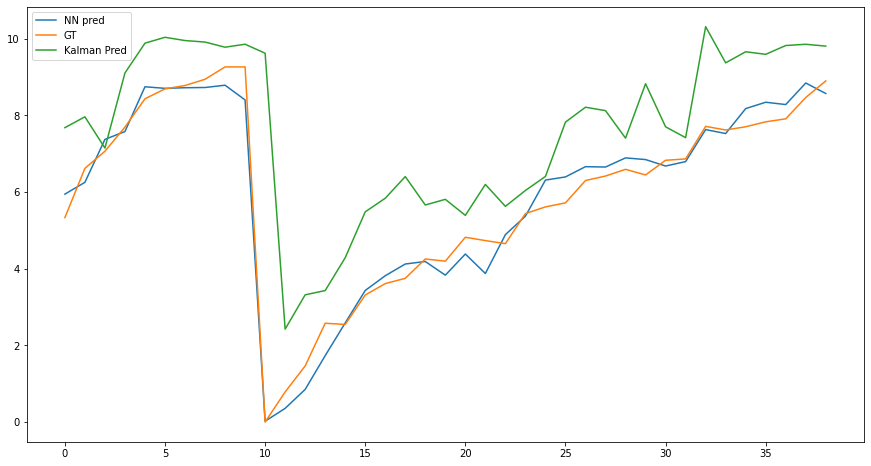

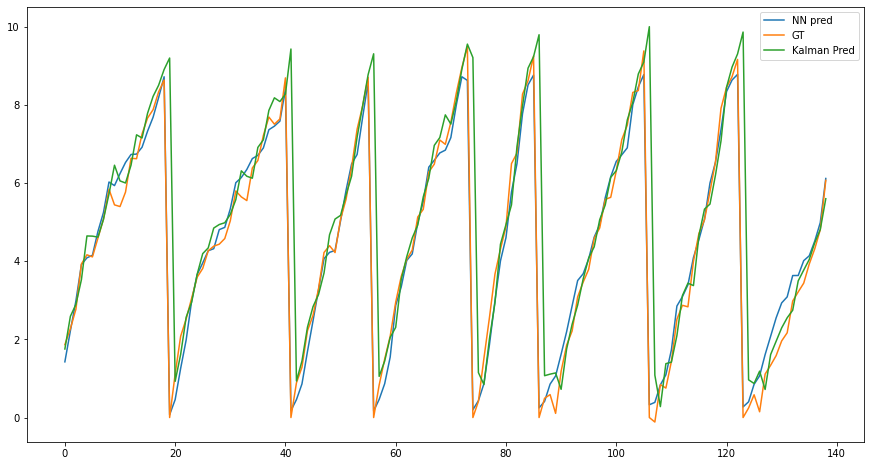

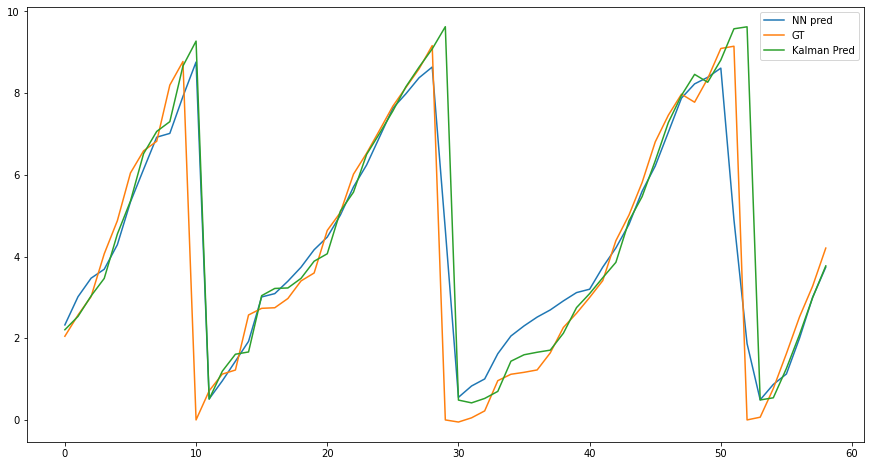

In [24]:
data_dim = 1
model_name = "RNN"
params, test_set_name = test_setup(data_dim=1, model_name=model_name)
params['batch_size'] = 20
all_resutls_df = get_results(params, test_set_name, model_name=model_name, data_dim=data_dim)
save_results(all_resutls_df, data_dim=1, model_name=model_name)
all_resutls_df
